# Chapter 2
## Title: Match Images and Captions Using CLIP

## 2.1 Downloading and Preparing Data

In [1]:
! pip3 install -U torch==2.3.1
! pip3 install torchvision==0.17.2
! pip3 install pycocotools
! pip3 install transformers
! pip install timm

  Using cached torch-2.3.1-cp310-none-macosx_11_0_arm64.whl.metadata (26 kB)
Using cached torch-2.3.1-cp310-none-macosx_11_0_arm64.whl (61.0 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.2.2
    Uninstalling torch-2.2.2:
      Successfully uninstalled torch-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.17.2 requires torch==2.2.2, but you have torch 2.3.1 which is incompatible.
  Using cached torch-2.2.2-cp310-none-macosx_11_0_arm64.whl.metadata (25 kB)
Using cached torch-2.2.2-cp310-none-macosx_11_0_arm64.whl (59.7 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.3.1
    Uninstalling torch-2.3.1:
      Successfully uninstalled torch-2.3.1


In [ ]:
import torch
from torchvision import datasets, transforms
import bisect

In [4]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps")

In [5]:
# Define data transforms
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
# Load training data
train_dir = '../../Personal Git Repo/data/train2014'
val_dir = '../../Personal Git Repo/data/val2014'
train_ann_file = '../../Personal Git Repo/data/annotations/captions_train2014.json'
val_ann_file = '../../Personal Git Repo/data/annotations/captions_val2014.json'
# Images are <class 'PIL.Image.Image'> before transformation
train_data = datasets.CocoCaptions(root=train_dir, annFile=train_ann_file, transform=image_transform)
val_data = datasets.CocoCaptions(root=val_dir, annFile=val_ann_file, transform=image_transform)

loading annotations into memory...
Done (t=0.40s)
creating index...
index created!
loading annotations into memory...
Done (t=0.18s)
creating index...
index created!


In [8]:
print('Number of samples: ', len(train_data))
img, target = train_data[3] # load 4th sample

print("Image Size: ", img.size())
print("Image ", type(img))
print(target)

Number of samples:  82783
Image Size:  torch.Size([3, 224, 224])
Image  <class 'torch.Tensor'>
['A zebra grazing on lush green grass in a field.', 'Zebra reaching its head down to ground where grass is. ', 'The zebra is eating grass in the sun.', 'A lone zebra grazing in some green grass.', 'a Zebra grazing on grass in a green open field.']


In [9]:
class CocoCaptionsFlattened(torch.utils.data.Dataset):
    def __init__(self, coco_captions):
        self.coco_captions = coco_captions
        print("Number of images:", len(self.coco_captions))
        caption_counts = [len(captions) for _, captions in coco_captions]
        self.cumulative_counts = self._compute_cumulative_counts(caption_counts)
        print("Number of image x caption pairs:", self.cumulative_counts[-1])

    def _compute_cumulative_counts(self, counts):
        cumulative = [0]
        for count in counts:
            cumulative.append(cumulative[-1] + count)
        return cumulative

    def __len__(self):
        return self.cumulative_counts[-1]

    def __getitem__(self, index):
        # Find the image index corresponding to the flattened caption index
        image_idx = bisect.bisect_right(self.cumulative_counts, index) - 1
        caption_idx = index - self.cumulative_counts[image_idx]
        # print(index, image_idx, caption_idx)
        image, captions = self.coco_captions[image_idx]
        return image, captions[caption_idx]

In [10]:
train_data_flattened = CocoCaptionsFlattened(train_data)

Number of images: 82783
Number of image x caption pairs: 414113


In [11]:
val_data_flattened = CocoCaptionsFlattened(val_data)

Number of images: 40504
Number of image x caption pairs: 202654


In [12]:
img, caption = train_data_flattened[10] # load 4th sample

print("Image Size: ", img.size())
print(caption)

Image Size:  torch.Size([3, 224, 224])
A flower vase is sitting on a porch stand.


In [13]:
print(len(train_data_flattened))
print(len(val_data_flattened))

414113
202654


In [14]:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased", torch_dtype=torch.float16)

In [15]:
def encode_captions(captions):
    tokenized_caption = tokenizer(captions, padding=True, truncation=True, max_length=200)
    encoded_captions = {}
    for k in tokenized_caption.keys():
        encoded_captions[k] = [torch.tensor(value).to(device) for value in tokenized_caption[k]]
    return encoded_captions

In [16]:
def collate_fn(batch):
    # len batch = 32
    images, captions = zip(*batch)
    # len images = 32, len captions = 32

    # Transfer data to appropriate device
    images = [image.to(device) for image in images]
    images_batch = torch.stack(images)
    
    captions_batch = encode_captions(captions)
    for k in captions_batch.keys():
        captions_batch[k] = torch.stack(captions_batch[k])
    
    return images_batch, captions_batch

In [17]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data_flattened, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_data_flattened, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [18]:
## For debugging
for batch in train_loader:
    # Process the batch
    # batch is a tuple of size 2, each elem in tuple has size 32 (batch size)
    # first elem is a list of image tensors, second elem is a list of dicts (for encoded captions)
    print(len(batch))
    print(len(batch[0]))
    print(type(batch[0]))
    print(len(batch[1]))
    print(len(batch[1]['input_ids']))
    print(len(batch[1]['attention_mask']))
    print(type(batch[1]['input_ids']))
    print(type(batch[1]['attention_mask']))
    break  # To get only one sample

2
32
<class 'torch.Tensor'>
2
32
32
<class 'torch.Tensor'>
<class 'torch.Tensor'>


## 2.2 Encoding Images and Text Using CLIP

In [19]:
import timm
from torch import nn

In [20]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name="resnet50", pretrained=True, trainable=True
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

In [21]:
from transformers import DistilBertModel

In [22]:
class TextEncoder(nn.Module):
    def __init__(self, model_name="distilbert-base-uncased", trainable=True):
        super().__init__()
        self.model = DistilBertModel.from_pretrained(model_name)
            
        for p in self.model.parameters():
            p.requires_grad = trainable
            
    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state

        # print("Normalized last hidden: ", torch.norm(last_hidden_state, p=2, dim=-1))
        
        # Mean pooling
        mask_expanded = attention_mask.unsqueeze(-1).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_expanded, dim=1)
        sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)

        # print("Normalized sum embeddings: ", torch.norm(sum_embeddings, p=2, dim=-1))
        # print("Embedding variance:", torch.var(sum_embeddings, dim=-1))
        # print("Embedding mean:", torch.mean(sum_embeddings, dim=-1))
        
        return sum_embeddings / sum_mask

In [23]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=256,
        dropout=0.1
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [25]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=1.0,
        image_embedding=2048,
        text_embedding=768,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature
        self.loss_fn = nn.CrossEntropyLoss()

    ## TODO: Add snippets of this code between texts
    def forward(self, batch):
        # batch is a tuple of size 2
        # batch[0] is a tensor of 32 image tensors
        # batch[1] is a dict, with each value as a tensor of 32 tensors
        
        # Getting Image and Text Features
        image_features = self.image_encoder(batch[0])
        text_features = self.text_encoder(
            input_ids=batch[1]["input_ids"], attention_mask=batch[1]["attention_mask"]
        )

        image_embeddings = nn.functional.normalize(self.image_projection(image_features), dim=-1)
        text_embeddings = nn.functional.normalize(self.text_projection(text_features), dim=-1)

        # Calculating the Loss
        logits = (image_embeddings @ text_embeddings.T) / self.temperature

        # Targets (diagonal indices)
        batch_size = image_embeddings.size(0)
        targets = torch.arange(batch_size, device=logits.device)
        
        # Compute Loss
        loss_image_to_text = self.loss_fn(logits, targets)
        loss_text_to_image = self.loss_fn(logits.T, targets)
        loss = (loss_image_to_text + loss_text_to_image) / 2.0
        
        return loss

## 2.3 Training Model to Learn Image-to-Text Mapping

In [26]:
model = CLIPModel().to(device)

In [27]:
lr = 1e-3
weight_decay = 1e-3
optimizer = torch.optim.AdamW(
        model.parameters(), lr=lr, weight_decay=weight_decay
    )

In [28]:
patience = 2 # check plateau for 2 epochs
factor = 0.5 # Reduce learning rate by half
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=patience, factor=factor
    )

In [29]:
from tqdm import tqdm

In [30]:
def model_epoch(model, data_loader, optimizer=None, max_batches=None):
    if not max_batches:
        max_batches = len(data_loader)
    
    acc_loss = 0
    num_samples = 0
    
    tqdm_object = tqdm(data_loader, total=max_batches)

    curr_batch = 0
    for batch in tqdm_object:
        # batch is a tuple of size 2
        # batch[0] is a tensor of 32 image tensors
        # batch[1] is a dict with each value as tensor of 32 caption tensors
        
        curr_batch += 1
        if curr_batch > max_batches:
            break
        
        loss = model(batch)
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        count = len(batch[0]) # number of images in the batch
        num_samples += count
        acc_loss += loss.item() * count
        avg_loss = acc_loss / num_samples

        if optimizer:
            tqdm_object.set_postfix(train_loss=avg_loss, lr=optimizer.param_groups[0]['lr'])
        else:
            tqdm_object.set_postfix(valid_loss=avg_loss)
    return avg_loss

In [31]:
num_epochs = 1
best_loss = float('inf')
for epoch in range(num_epochs):
    print(f"Epoch: {epoch + 1}")
    model.train()
    try:
        train_loss = model_epoch(model=model, data_loader=train_loader, optimizer=optimizer, max_batches=500)
    except Exception as e:
        print("Exception occured:", e)
    model.eval()
    with torch.no_grad():
        valid_loss = model_epoch(model=model, data_loader=val_loader, max_batches=500)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), "best.pt")
        print("Saved Best Model!")
    lr_scheduler.step(valid_loss)

Epoch: 1


100%|████████████████████████████████████████████████████████████████████████████| 500/500 [03:35<00:00,  2.32it/s, valid_loss=3.47]


Saved Best Model!


## 2.4 Inferring Best Matching Image, Text Pairs

In [32]:
model_path = "best.pt"
model = CLIPModel().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

CLIPModel(
  (image_encoder): ImageEncoder(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act2): ReLU(inplace=True)
          (aa): Identity()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

In [33]:
image_dataset = datasets.ImageFolder(root="../../Personal Git Repo/data/imagenette2/val", transform=image_transform)

In [34]:
print('Number of samples: ', len(image_dataset))
type(image_dataset)

Number of samples:  3925


torchvision.datasets.folder.ImageFolder

In [35]:
caption_dataset = [
    "Photo of a fish",
    "Photo of a dog",
    "Photo of a cassette player",
    "Photo of a chainsaw",
    "Photo of a church",
    "Photo of a French horn",
    "Photo of a garbage truck",
    "Photo of a gas pump",
    "Photo of a golf ball",
    "Photo of a parachute"
]

In [36]:
caption_dataset = [
    "fish",
    "dog",
    "cassette player",
    "chainsaw",
    "church",
    "French horn",
    "garbage truck",
    "gas pump",
    "golf ball",
    "parachute"
]

### 2.4.1 Get Best Matching Caption for a Given Image

In [40]:
import random

class Image2Caption:
    def __init__(self, caption_dataset):
        # Get embeddings of all captions
        encoded_captions = encode_captions(caption_dataset)
        # print(encoded_captions["input_ids"]) # all different
        with torch.no_grad():
            captions_features = model.text_encoder(input_ids=torch.stack(encoded_captions["input_ids"]), attention_mask=torch.stack(encoded_captions["attention_mask"]))
            # print(torch.norm(captions_features, p=2, dim=-1))
            self.caption_embeddings = model.text_projection(captions_features)
    
    def get_random_image(self, image_dataset):
        random_index = random.randint(0, len(image_dataset)-1)
        image, label = image_dataset[random_index]
        return image, label

    def get_image_embeddings(self, image):
        with torch.no_grad():
            image_features = model.image_encoder(image)
            image_embeddings = model.image_projection(image_features)
            return image_embeddings

    def get_caption(self, image):
        # Get image embeddings
        image_tensor = image.unsqueeze(0).to(device)
        image_embeddings = self.get_image_embeddings(image_tensor).to(device)

        # print(torch.norm(self.caption_embeddings, p=2, dim=-1)) # all same

        # Calculate similarity scores of image with all captions
        image_embeddings_n = nn.functional.normalize(image_embeddings, dim=-1)
        text_embeddings_n = nn.functional.normalize(self.caption_embeddings, dim=-1)
        dot_similarity = image_embeddings_n @ text_embeddings_n.T

        # print(dot_similarity)

        # Return caption with maximum similarity score
        max_index = torch.argmax(dot_similarity)
        print(max_index)
        matched_caption = caption_dataset[max_index]
        return matched_caption

In [41]:
i2c = Image2Caption(caption_dataset)

In [42]:
# Inverse transformation
import numpy as np
from PIL import Image

def tensor2PIL(image_tensor):
    reverted_image = image_tensor.numpy().transpose(1, 2, 0)
    reverted_image = reverted_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    reverted_image = (reverted_image * 255).astype('uint8')
    reverted_image = Image.fromarray(reverted_image)
    return reverted_image

tensor(4, device='mps:0')
church


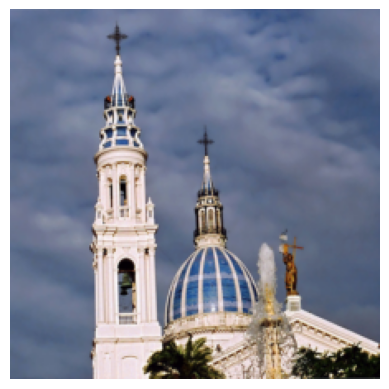

In [43]:
import matplotlib.pyplot as plt

image, label = i2c.get_random_image(image_dataset)
image_caption = i2c.get_caption(image)
print(image_caption)

plt.imshow(tensor2PIL(image))
plt.axis('off')  # Optional: Hide axis ticks and labels
plt.show()

### 2.4.2 Get Best Matching Images for a given Caption

In [44]:
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

class Caption2Image:
    def __init__(self, image_dataset):
        self.image_dataset = image_dataset
        data_loader = torch.utils.data.DataLoader(image_dataset, batch_size=32, shuffle=False)
        self.all_image_embeddings = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # batch[0] is batch of image tensors, batch[1] is batch of class labels
                image_features = model.image_encoder(batch[0].to(device))
                image_embeddings = model.image_projection(image_features)
                self.all_image_embeddings.append(image_embeddings)
        self.all_image_embeddings = torch.cat(self.all_image_embeddings)
    
    def get_random_caption(self, caption_dataset):
        random_index = random.randint(0, len(caption_dataset)-1)
        caption = caption_dataset[random_index]
        return caption

    def get_caption_embeddings(self, caption):
        encoded_caption = encode_captions([caption])
        with torch.no_grad():
            captions_features = model.text_encoder(
                input_ids=torch.stack(encoded_caption["input_ids"]), 
                attention_mask=torch.stack(encoded_caption["attention_mask"]))
            caption_embeddings = model.text_projection(captions_features)
        return caption_embeddings

    def get_images(self, caption):
        # Get caption's text embeddings
        caption_embeddings = self.get_caption_embeddings(caption)

        # Calculate similarity score
        image_embeddings_n = torch.nn.functional.normalize(self.all_image_embeddings, p=2, dim=-1)
        text_embeddings_n = torch.nn.functional.normalize(caption_embeddings, p=2, dim=-1)
        dot_similarity = text_embeddings_n @ image_embeddings_n.T

        _, indices = torch.topk(dot_similarity.squeeze(0), 9)
        return indices

In [45]:
def show_images(indices):
    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    
    matches = [image_dataset[idx][0] for idx in indices]
    for match, ax in zip(matches, axes.flatten()):
        image = match.numpy().transpose(1, 2, 0)
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image = (image * 255).astype('uint8')
        image = Image.fromarray(image)
        ax.imshow(image)
        ax.axis("off")

    plt.show()

In [46]:
c2i = Caption2Image(image_dataset)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:30<00:00,  3.98it/s]


parachute


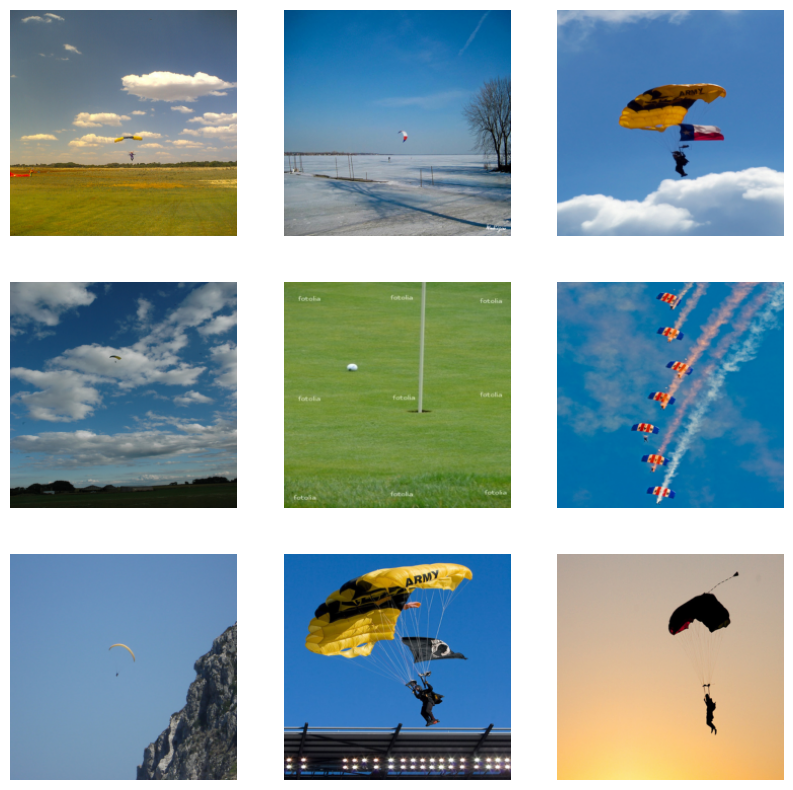

In [47]:
caption = c2i.get_random_caption(caption_dataset)
print(caption)
indices = c2i.get_images(caption)
show_images(indices)